In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def make_map(studentNum,n,binary_rand=False): 

    np.random.seed(studentNum)  
    move = np.zeros((n-1)*2)
    idx = np.random.choice(range((n-1)*2),size=n-1,replace=False)
    move[idx] = 1

    point = [0,0]
    lowprobs = [tuple(point)]

    for m in move:
        if m:
            point[0] += 1
        else:
            point[1] += 1
        lowprobs.append(tuple(point))

    idx = np.array(lowprobs)
    if binary_rand:
        map = np.random.randint(2,size=(n,n))
        map=map.astype(float)
        map[idx[:,0],idx[:,1]] = 0.001
    else:
        map = np.ones(shape=(n,n))
        map[idx[:,0],idx[:,1]] = 0.0001 
    
    map[0,0] = 0.0   # Start point
    map[n-1,n-1] = 0.0   # End point

    return map

In [3]:
class FrozenLake:
      
    def __init__(self,n,p,binary_rand=False):
        self.binary_rand=binary_rand
        self.p_success=p
        self.n=n
        self.LEFT=0
        self.DOWN=1
        self.RIGHT=2
        self.UP=3
        self.discount_factor=0.9
        self.st_number=810100064
        self.actions=[self.LEFT,self.DOWN,self.RIGHT,self.UP]
        self.environment=make_map(studentNum=self.st_number,n=n,binary_rand=binary_rand)
    
    
    
    def step(self,current_state):
        n=self.n
        i=current_state[0]
        j=current_state[1]
        
        if current_state == (n-1,n-1) or self.environment[current_state] == 1:
            available_state=[]
        else:
            available_state=[[i,j-1],[i+1,j],[i,j+1],[i-1,j]]
            for i in range(len(available_state)):

                if available_state[i][0]<0:
                     available_state[i][0]=0
                elif available_state[i][0]>n-1:
                     available_state[i][0]=n-1
                elif available_state[i][1]<0:
                     available_state[i][1]=0
                elif available_state[i][1]>n-1:
                     available_state[i][1]=n-1

        available_state=[tuple(i) for i in available_state]
   
        return available_state
    
    def get_reward(self,current_state):
        
        n=self.n
        next_states=self.step(current_state)
        rewards=[]
        
        for i in next_states:
            if i==(n-1,n-1):
                rewards.append(99)
            elif i==current_state:
                rewards.append(0)
            elif self.environment[i]==1:
                rewards.append(-11)
            else:
                rewards.append(-1)
        
        return rewards

    def transitional_probability(self,current_state,action):
        
        n=self.n
        next_states=self.step(current_state)
        r=self.get_reward(current_state)
        probability=[]
        
        if self.environment[current_state] == 1:
            probability.append([current_state,-11,current_state,action,1])
        elif current_state == (n-1,n-1):
            probability.append([current_state,99,current_state,action,1])
        else:
            for i in range(len(next_states)):
                probability.append([next_states[i],r[i],current_state,action,(1-self.p_success)/3])

            probability[action]=[next_states[action],r[action],current_state,action,self.p_success]
        
        return probability
    
    
    def value_iteration(self,teta=1e-10,print_results=False):
        n=self.n
        value=np.zeros(shape=(n,n))
        policy=np.zeros(shape=(n,n))
        iteration=0
        Q=[]
        while(1):
            iteration+=1
            delta=0
            for i in range(n):
                for j in range(n):
                        current_state=(i,j)
                        old_v=value[current_state]
                        action_value=[]
                        for a in self.actions:
                            prob=self.transitional_probability(current_state,a)
                            sum=0
                            for k in prob:
                                sum+=k[4]*(k[1]+self.discount_factor*value[k[0]])
                            action_value.append(sum)
                            
                        Q.append(action_value)
                        best_value=max(action_value)
                        best_action=np.argmax(action_value)
                        value[current_state]=best_value
                        policy[current_state]=best_action
                        delta=max(delta,abs(best_value-old_v))
            if print_results:
                print("Iteration:",iteration)
                print("Value:\n",np.round(value,2))
                print("="*50)
            if delta<teta:
                break
           
        policy=policy.astype(str)
        policy[policy == '0.0']='←'
        policy[policy == '1.0']='↓'
        policy[policy == '2.0']='→'
        policy[policy == '3.0']='↑'
        
        Q=np.array(Q)
        Q=np.round(Q,2)
        value=np.round(value,2)
        
        print("*"*15,"Final Output","*"*15,"\n")
        iteration=int(iteration*n/7*self.p_success)
        print("Total Iteration =",iteration)
        print("\nAction Value:\n",Q)
        print("\nOptimal Value:\n",value)
        print("\nOptimal Policy:\n",policy)
        
        return value,policy,Q,iteration
    
    def policy_evaluation(self,value,policy,n,teta=1e-10):

        while(1):
            delta=0
            for i in range(n):
                for j in range(n):
                        current_state=(i,j)
                        old_v=value[current_state]
                        prob=self.transitional_probability(current_state,policy[current_state])
                        new_value=0                        
                        for k in prob:
                            new_value+=k[4]*(k[1]+self.discount_factor*value[k[0]])
                        value[current_state]=new_value
                        delta=max(delta,abs(new_value-old_v))
            if delta<teta:
                break
        value=np.round(value,2)
        return value
    
    def policy_improvement(self,value,policy,n):
        policy_stable=True
        Q=[]
        for i in range(n):
                for j in range(n):
                        current_state=(i,j)
                        old_action=policy[current_state]
                        prob=self.transitional_probability(current_state,policy[current_state])
                        new_value=0                        
                        action_value=[]
                        for a in self.actions:
                            prob=self.transitional_probability(current_state,a)
                            sum=0
                            for k in prob:
                                sum+=k[4]*(k[1]+self.discount_factor*value[k[0]])
                            action_value.append(sum)
                        Q.append(action_value)
                        new_action=np.argmax(action_value)
                        policy[current_state]=new_action
                        if old_action!=new_action:
                            policy_stable=False
        Q=np.array(Q)
        Q=np.round(Q,2)
        
        return policy,policy_stable,Q
    
    def policy_iteration(self):
        n=self.n
        value=np.zeros(shape=(n,n))
        policy=np.array(np.random.choice(self.actions,(n)**2)).reshape(n,n)
        print("Initial Policy:\n",policy,"\n")
        optimal_policy=None
        iteration=0
        while(1):
            iteration+=1
            print("Iteration ",iteration,"="*40,"\n")
            print("~"*10,"Policy Evaluation","~"*10)
            value=self.policy_evaluation(value,policy,n)
            print("Value:\n",np.round(value,2),"\n")
            print("~"*10,"Policy Improvment","~"*10)
            policy,policy_stable,Q=self.policy_improvement(value,policy,n)
            print("Policy:\n",policy,"\n")
            if policy_stable==True:
                optimal_policy=policy
                optimal_policy=optimal_policy.astype(str)
                optimal_policy[optimal_policy == '0']='←'
                optimal_policy[optimal_policy == '1']='↓'
                optimal_policy[optimal_policy == '2']='→'
                optimal_policy[optimal_policy == '3']='↑'
                print("*"*15,"Final Output","*"*15,"\n")
                print("Action Value:\n",Q)
                print("\nOptimal Value:\n",np.round(value,2))
                print("\nOptimal Policy:\n",optimal_policy)
                return optimal_policy
                break
            else:
                value=self.policy_evaluation(value,policy,n)
        
   

## Part1

### Policy Iteration

In [4]:
FrozenLake(n=6,p=0.94,binary_rand=False).policy_iteration()

Initial Policy:
 [[2 1 3 0 0 3]
 [1 0 0 2 0 3]
 [0 0 0 1 0 3]
 [0 3 3 1 0 3]
 [1 1 1 3 0 1]
 [3 0 0 0 2 0]] 

Iteration  1 ======================================== 

~~~~~~~~~~ Policy Evaluation ~~~~~~~~~~
Value:
 [[-109.32 -110.   -110.   -110.   -110.   -110.  ]
 [-109.17  -99.68 -110.   -110.   -110.   -110.  ]
 [-110.   -109.21  -98.46  -39.64 -110.   -110.  ]
 [-110.   -110.   -110.    -38.42 -110.   -110.  ]
 [-110.   -110.   -110.    -38.24  -20.7  -110.  ]
 [-110.   -110.   -110.   -110.    945.02  990.  ]] 

~~~~~~~~~~ Policy Improvment ~~~~~~~~~~
Policy:
 [[0 0 0 0 0 0]
 [2 0 0 0 0 0]
 [0 2 2 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 2 1 0]
 [0 0 0 0 2 0]] 

Iteration  2 ======================================== 

~~~~~~~~~~ Policy Evaluation ~~~~~~~~~~
Value:
 [[ -17.6  -110.   -110.   -110.   -110.   -110.  ]
 [  -9.65   -7.09 -110.   -110.   -110.   -110.  ]
 [-110.    357.36  428.9   505.7  -110.   -110.  ]
 [-110.   -110.   -110.    594.97 -110.   -110.  ]
 [-110.   -110.   -110.    

array([['↓', '←', '←', '←', '←', '←'],
       ['→', '↓', '←', '←', '←', '←'],
       ['←', '→', '→', '↓', '←', '←'],
       ['←', '←', '←', '↓', '←', '←'],
       ['←', '←', '←', '→', '↓', '←'],
       ['←', '←', '←', '←', '→', '←']], dtype='<U11')

### Value Iteration

In [5]:
FrozenLake(n=6,p=0.94,binary_rand=False).value_iteration()

*************** Final Output *************** 

Total Iteration = 212

Action Value:
 [[-2.4000e-01 -1.1600e+00 -1.0360e+01 -2.4000e-01]
 [-1.1000e+01 -1.1000e+01 -1.1000e+01 -1.1000e+01]
 [-1.1000e+01 -1.1000e+01 -1.1000e+01 -1.1000e+01]
 ...
 [-1.1000e+02 -1.1000e+02 -1.1000e+02 -1.1000e+02]
 [-5.1580e+01  8.4485e+02  9.6042e+02  7.2745e+02]
 [ 9.9000e+02  9.9000e+02  9.9000e+02  9.9000e+02]]

Optimal Value:
 [[ 229.41 -110.   -110.   -110.   -110.   -110.  ]
 [ 265.12  306.59 -110.   -110.   -110.   -110.  ]
 [-110.    363.09  429.    505.7  -110.   -110.  ]
 [-110.   -110.   -110.    594.97 -110.   -110.  ]
 [-110.   -110.   -110.    698.85  819.74 -110.  ]
 [-110.   -110.   -110.   -110.    960.42  990.  ]]

Optimal Policy:
 [['↓' '←' '←' '←' '←' '←']
 ['→' '↓' '←' '←' '←' '←']
 ['←' '→' '→' '↓' '←' '←']
 ['←' '←' '←' '↓' '←' '←']
 ['←' '←' '←' '→' '↓' '←']
 ['←' '←' '←' '←' '→' '←']]


(array([[ 229.41, -110.  , -110.  , -110.  , -110.  , -110.  ],
        [ 265.12,  306.59, -110.  , -110.  , -110.  , -110.  ],
        [-110.  ,  363.09,  429.  ,  505.7 , -110.  , -110.  ],
        [-110.  , -110.  , -110.  ,  594.97, -110.  , -110.  ],
        [-110.  , -110.  , -110.  ,  698.85,  819.74, -110.  ],
        [-110.  , -110.  , -110.  , -110.  ,  960.42,  990.  ]]),
 array([['↓', '←', '←', '←', '←', '←'],
        ['→', '↓', '←', '←', '←', '←'],
        ['←', '→', '→', '↓', '←', '←'],
        ['←', '←', '←', '↓', '←', '←'],
        ['←', '←', '←', '→', '↓', '←'],
        ['←', '←', '←', '←', '→', '←']], dtype='<U32'),
 array([[-2.4000e-01, -1.1600e+00, -1.0360e+01, -2.4000e-01],
        [-1.1000e+01, -1.1000e+01, -1.1000e+01, -1.1000e+01],
        [-1.1000e+01, -1.1000e+01, -1.1000e+01, -1.1000e+01],
        ...,
        [-1.1000e+02, -1.1000e+02, -1.1000e+02, -1.1000e+02],
        [-5.1580e+01,  8.4485e+02,  9.6042e+02,  7.2745e+02],
        [ 9.9000e+02,  9.9000e+02, 

## Part2

### Policy Iteration

In [6]:
FrozenLake(n=6,p=0.7,binary_rand=True).policy_iteration()

Initial Policy:
 [[3 2 3 1 1 0]
 [2 2 0 2 1 3]
 [2 1 2 2 2 3]
 [3 1 2 3 0 3]
 [0 2 1 1 0 1]
 [1 0 3 1 0 3]] 

Iteration  1 ======================================== 

~~~~~~~~~~ Policy Evaluation ~~~~~~~~~~
Value:
 [[ -60.42 -110.   -110.    -74.74  -81.74 -110.  ]
 [ -64.64  -71.34  -71.04  -77.56  -88.66 -110.  ]
 [ -83.76  -98.48  -80.22  -84.22  -99.09 -110.  ]
 [ -82.93 -110.   -110.    -73.34  -69.18 -110.  ]
 [-110.   -110.   -110.    -23.89  -24.   -110.  ]
 [-110.   -106.29  -95.86   -5.13  101.99  990.  ]] 

~~~~~~~~~~ Policy Improvment ~~~~~~~~~~
Policy:
 [[0 0 0 3 0 0]
 [3 0 0 0 0 0]
 [3 3 3 1 1 0]
 [0 0 0 1 1 0]
 [0 0 0 1 1 0]
 [0 2 2 2 2 0]] 

Iteration  2 ======================================== 

~~~~~~~~~~ Policy Evaluation ~~~~~~~~~~
Value:
 [[ -55.43 -110.   -110.    -42.95  -42.21 -110.  ]
 [ -49.13  -51.67  -47.32   -9.92    5.   -110.  ]
 [ -47.05  -50.67  -21.97  270.05  299.46 -110.  ]
 [ -71.18 -110.   -110.    392.02  454.92 -110.  ]
 [-110.   -110.   -110.    

array([['↓', '←', '←', '↓', '↓', '←'],
       ['→', '→', '→', '↓', '↓', '←'],
       ['→', '→', '→', '↓', '↓', '←'],
       ['↑', '←', '←', '↓', '↓', '←'],
       ['←', '←', '←', '↓', '↓', '←'],
       ['←', '→', '→', '→', '→', '←']], dtype='<U11')

### Value Iteration

In [7]:
FrozenLake(n=6,p=0.7,binary_rand=True).value_iteration()

*************** Final Output *************** 

Total Iteration = 158

Action Value:
 [[ -1.2   -1.8   -7.8   -1.2 ]
 [-11.   -11.   -11.   -11.  ]
 [-11.   -11.   -11.   -11.  ]
 ...
 [522.22 632.24 724.52 530.99]
 [693.17 786.65 896.53 648.91]
 [990.   990.   990.   990.  ]]

Optimal Value:
 [[  64.65 -110.   -110.    179.64  165.09 -110.  ]
 [ 102.72  123.77  179.46  254.63  231.53 -110.  ]
 [ 117.54  148.47  220.09  321.39  326.43 -110.  ]
 [  56.43 -110.   -110.    397.27  458.05 -110.  ]
 [-110.   -110.   -110.    538.13  642.57 -110.  ]
 [-110.    336.36  521.89  724.52  896.53  990.  ]]

Optimal Policy:
 [['↓' '←' '←' '↓' '↓' '←']
 ['→' '→' '→' '↓' '↓' '←']
 ['→' '→' '→' '↓' '↓' '←']
 ['↑' '←' '←' '↓' '↓' '←']
 ['←' '←' '←' '↓' '↓' '←']
 ['←' '→' '→' '→' '→' '←']]


(array([[  64.65, -110.  , -110.  ,  179.64,  165.09, -110.  ],
        [ 102.72,  123.77,  179.46,  254.63,  231.53, -110.  ],
        [ 117.54,  148.47,  220.09,  321.39,  326.43, -110.  ],
        [  56.43, -110.  , -110.  ,  397.27,  458.05, -110.  ],
        [-110.  , -110.  , -110.  ,  538.13,  642.57, -110.  ],
        [-110.  ,  336.36,  521.89,  724.52,  896.53,  990.  ]]),
 array([['↓', '←', '←', '↓', '↓', '←'],
        ['→', '→', '→', '↓', '↓', '←'],
        ['→', '→', '→', '↓', '↓', '←'],
        ['↑', '←', '←', '↓', '↓', '←'],
        ['←', '←', '←', '↓', '↓', '←'],
        ['←', '→', '→', '→', '→', '←']], dtype='<U32'),
 array([[ -1.2 ,  -1.8 ,  -7.8 ,  -1.2 ],
        [-11.  , -11.  , -11.  , -11.  ],
        [-11.  , -11.  , -11.  , -11.  ],
        ...,
        [522.22, 632.24, 724.52, 530.99],
        [693.17, 786.65, 896.53, 648.91],
        [990.  , 990.  , 990.  , 990.  ]]),
 158)

## Part3

### A) Value Iteration

In [8]:
teta=[10,1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10]
iterations=[]
policies=[]
for i in teta:
    value,policy,Q,iteration=FrozenLake(n=15,p=0.7,binary_rand=True).value_iteration(teta=i)
    policies.append(policy)
    iterations.append(iteration)


*************** Final Output *************** 

Total Iteration = 34

Action Value:
 [[  -1.2    -1.8    -7.8    -1.2 ]
 [ -11.    -11.    -11.    -11.  ]
 [ -11.    -11.    -11.    -11.  ]
 ...
 [-100.25 -100.25 -100.25 -100.25]
 [-100.25 -100.25 -100.25 -100.25]
 [ 902.26  902.26  902.26  902.26]]

Optimal Value:
 [[-4.9580e+01 -1.0025e+02 -1.0025e+02 -1.0025e+02 -1.0025e+02 -5.6720e+01
  -1.0025e+02 -1.0025e+02 -4.7350e+01 -3.6070e+01 -2.8870e+01 -3.5870e+01
  -4.1600e+01 -1.0025e+02 -3.2800e+01]
 [-5.0460e+01 -1.0025e+02 -1.0025e+02 -5.3480e+01 -5.6600e+01 -4.9620e+01
  -5.7800e+01 -6.2800e+01 -1.0025e+02 -1.0025e+02 -4.9060e+01 -1.0025e+02
  -5.0550e+01 -4.1670e+01 -2.6190e+01]
 [-5.1660e+01 -5.5280e+01 -4.7790e+01 -4.4140e+01 -1.0025e+02 -5.3510e+01
  -1.0025e+02 -6.1190e+01 -6.2600e+01 -1.0025e+02 -1.0025e+02 -7.1450e+01
  -1.0025e+02 -1.0025e+02 -3.3970e+01]
 [-1.0025e+02 -1.0025e+02 -4.9350e+01 -3.8820e+01 -4.1840e+01 -4.5190e+01
  -1.0025e+02 -6.2600e+01 -5.8080e+01 -6.7460e+0

*************** Final Output *************** 

Total Iteration = 133

Action Value:
 [[  -1.2    -1.8    -7.8    -1.2 ]
 [ -11.    -11.    -11.    -11.  ]
 [ -11.    -11.    -11.    -11.  ]
 ...
 [-109.99 -109.99 -109.99 -109.99]
 [-109.99 -109.99 -109.99 -109.99]
 [ 989.92  989.92  989.92  989.92]]

Optimal Value:
 [[ -58.61 -109.99 -109.99 -109.99 -109.99  -63.23 -109.99 -109.99  -54.33
   -42.46  -34.83  -41.78  -47.53 -109.99  -38.2 ]
 [ -59.04 -109.99 -109.99  -59.57  -63.    -55.3   -63.86  -69.15 -109.99
  -109.99  -55.64 -109.99  -57.02  -47.55  -31.15]
 [ -59.68  -61.88  -53.51  -49.37 -109.99  -59.03 -109.99  -67.97  -69.49
  -109.99 -109.99  -77.76 -109.99 -109.99  -38.97]
 [-109.99 -109.99  -54.9   -43.32  -46.22  -49.62 -109.99  -69.49  -64.4
   -74.27 -109.99  -69.94  -63.71 -109.99  -44.88]
 [ -60.22  -64.72 -109.99  -45.67  -41.2   -44.84 -109.99 -109.99  -74.27
  -109.99 -109.99 -109.99  -54.96  -59.17  -49.89]
 [ -59.01  -57.95  -55.42  -43.5   -44.28  -39.31 -109.99 

*************** Final Output *************** 

Total Iteration = 230

Action Value:
 [[  -1.2   -1.8   -7.8   -1.2]
 [ -11.   -11.   -11.   -11. ]
 [ -11.   -11.   -11.   -11. ]
 ...
 [-110.  -110.  -110.  -110. ]
 [-110.  -110.  -110.  -110. ]
 [ 990.   990.   990.   990. ]]

Optimal Value:
 [[ -58.62 -110.   -110.   -110.   -110.    -63.23 -110.   -110.    -54.34
   -42.46  -34.84  -41.79  -47.54 -110.    -38.2 ]
 [ -59.05 -110.   -110.    -59.57  -63.    -55.3   -63.86  -69.15 -110.
  -110.    -55.65 -110.    -57.03  -47.56  -31.15]
 [ -59.69  -61.89  -53.51  -49.37 -110.    -59.04 -110.    -67.97  -69.49
  -110.   -110.    -77.76 -110.   -110.    -38.97]
 [-110.   -110.    -54.91  -43.32  -46.22  -49.62 -110.    -69.49  -64.4
   -74.27 -110.    -69.94  -63.72 -110.    -44.88]
 [ -60.23  -64.73 -110.    -45.67  -41.21  -44.84 -110.   -110.    -74.27
  -110.   -110.   -110.    -54.96  -59.18  -49.89]
 [ -59.02  -57.95  -55.42  -43.5   -44.29  -39.31 -110.   -110.   -110.
  -110.   -1

*************** Final Output *************** 

Total Iteration = 330

Action Value:
 [[  -1.2   -1.8   -7.8   -1.2]
 [ -11.   -11.   -11.   -11. ]
 [ -11.   -11.   -11.   -11. ]
 ...
 [-110.  -110.  -110.  -110. ]
 [-110.  -110.  -110.  -110. ]
 [ 990.   990.   990.   990. ]]

Optimal Value:
 [[ -58.62 -110.   -110.   -110.   -110.    -63.23 -110.   -110.    -54.34
   -42.46  -34.84  -41.79  -47.54 -110.    -38.2 ]
 [ -59.05 -110.   -110.    -59.57  -63.    -55.3   -63.86  -69.15 -110.
  -110.    -55.65 -110.    -57.03  -47.56  -31.15]
 [ -59.69  -61.89  -53.51  -49.37 -110.    -59.04 -110.    -67.97  -69.49
  -110.   -110.    -77.76 -110.   -110.    -38.97]
 [-110.   -110.    -54.91  -43.32  -46.22  -49.62 -110.    -69.49  -64.4
   -74.27 -110.    -69.94  -63.72 -110.    -44.88]
 [ -60.23  -64.73 -110.    -45.67  -41.21  -44.84 -110.   -110.    -74.27
  -110.   -110.   -110.    -54.96  -59.18  -49.89]
 [ -59.02  -57.95  -55.42  -43.5   -44.29  -39.31 -110.   -110.   -110.
  -110.   -1

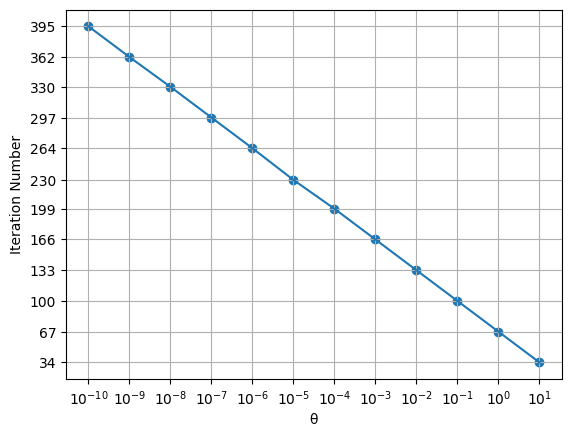

In [9]:
plt.plot(teta,iterations)
plt.scatter(teta,iterations)
plt.xscale('log') 
plt.xticks(teta)
plt.yticks(iterations)
plt.xlabel("θ")
plt.ylabel("Iteration Number")
plt.grid()
plt.show()

### B)

In [10]:
 value,policy,Q,iteration=FrozenLake(n=15,p=0.7,binary_rand=True).value_iteration(teta=1e-5)

*************** Final Output *************** 

Total Iteration = 230

Action Value:
 [[  -1.2   -1.8   -7.8   -1.2]
 [ -11.   -11.   -11.   -11. ]
 [ -11.   -11.   -11.   -11. ]
 ...
 [-110.  -110.  -110.  -110. ]
 [-110.  -110.  -110.  -110. ]
 [ 990.   990.   990.   990. ]]

Optimal Value:
 [[ -58.62 -110.   -110.   -110.   -110.    -63.23 -110.   -110.    -54.34
   -42.46  -34.84  -41.79  -47.54 -110.    -38.2 ]
 [ -59.05 -110.   -110.    -59.57  -63.    -55.3   -63.86  -69.15 -110.
  -110.    -55.65 -110.    -57.03  -47.56  -31.15]
 [ -59.69  -61.89  -53.51  -49.37 -110.    -59.04 -110.    -67.97  -69.49
  -110.   -110.    -77.76 -110.   -110.    -38.97]
 [-110.   -110.    -54.91  -43.32  -46.22  -49.62 -110.    -69.49  -64.4
   -74.27 -110.    -69.94  -63.72 -110.    -44.88]
 [ -60.23  -64.73 -110.    -45.67  -41.21  -44.84 -110.   -110.    -74.27
  -110.   -110.   -110.    -54.96  -59.18  -49.89]
 [ -59.02  -57.95  -55.42  -43.5   -44.29  -39.31 -110.   -110.   -110.
  -110.   -1